<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

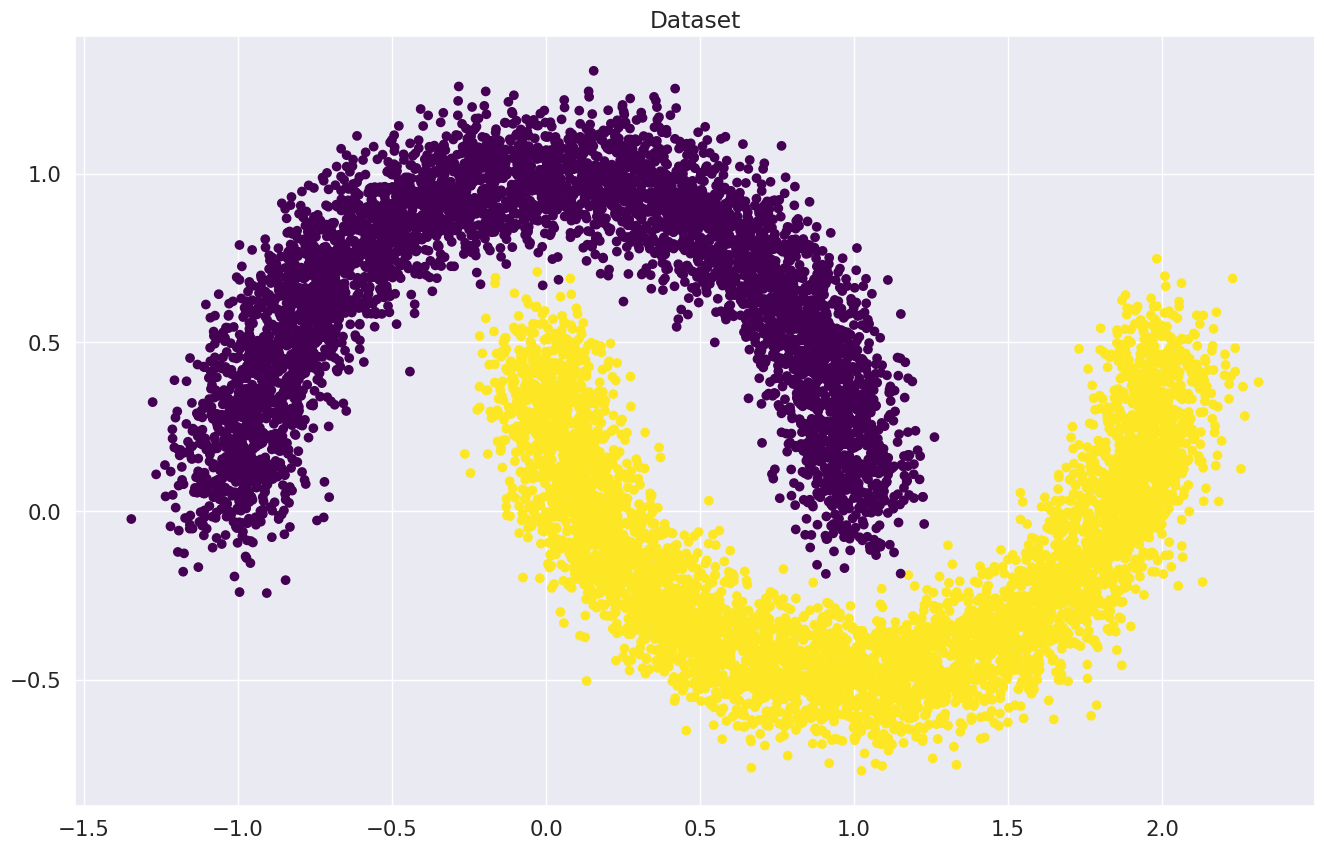

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t =  torch.tensor(X_train, dtype=torch.float32)
y_train_t =  torch.tensor(y_train, dtype=torch.float32)
X_val_t =  torch.tensor(X_val, dtype=torch.float32)
y_val_t =  torch.tensor(y_val, dtype=torch.float32)

Создаем `Dataset` и `DataLoader`.

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [35]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

In [36]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [25]:
print(list(linear_regression.parameters()))
count_params = sum([len(params) for params in linear_regression.parameters()])

print(f"\nКол-во параметров: {count_params}")

[Parameter containing:
tensor([-1.5090,  0.1321], requires_grad=True), Parameter containing:
tensor([-1.4259], requires_grad=True)]

Кол-во параметров: 3


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [37]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        loss = loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = 1 / (1 + torch.exp(-outp))
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.4375
Iteration: 100
Batch accuracy: 0.8515625
Iteration: 200
Batch accuracy: 0.875
Iteration: 300
Batch accuracy: 0.9296875
Iteration: 400
Batch accuracy: 0.8984375
Iteration: 500
Batch accuracy: 0.9296875

Iteration: 519.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 519

### Визуализируем результаты

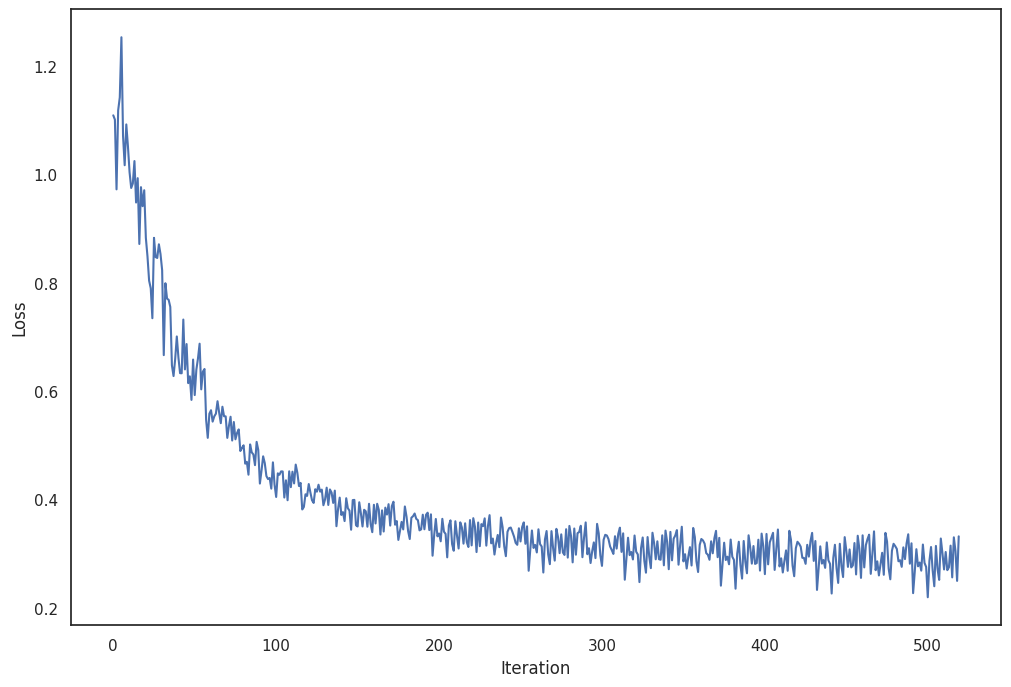

In [38]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

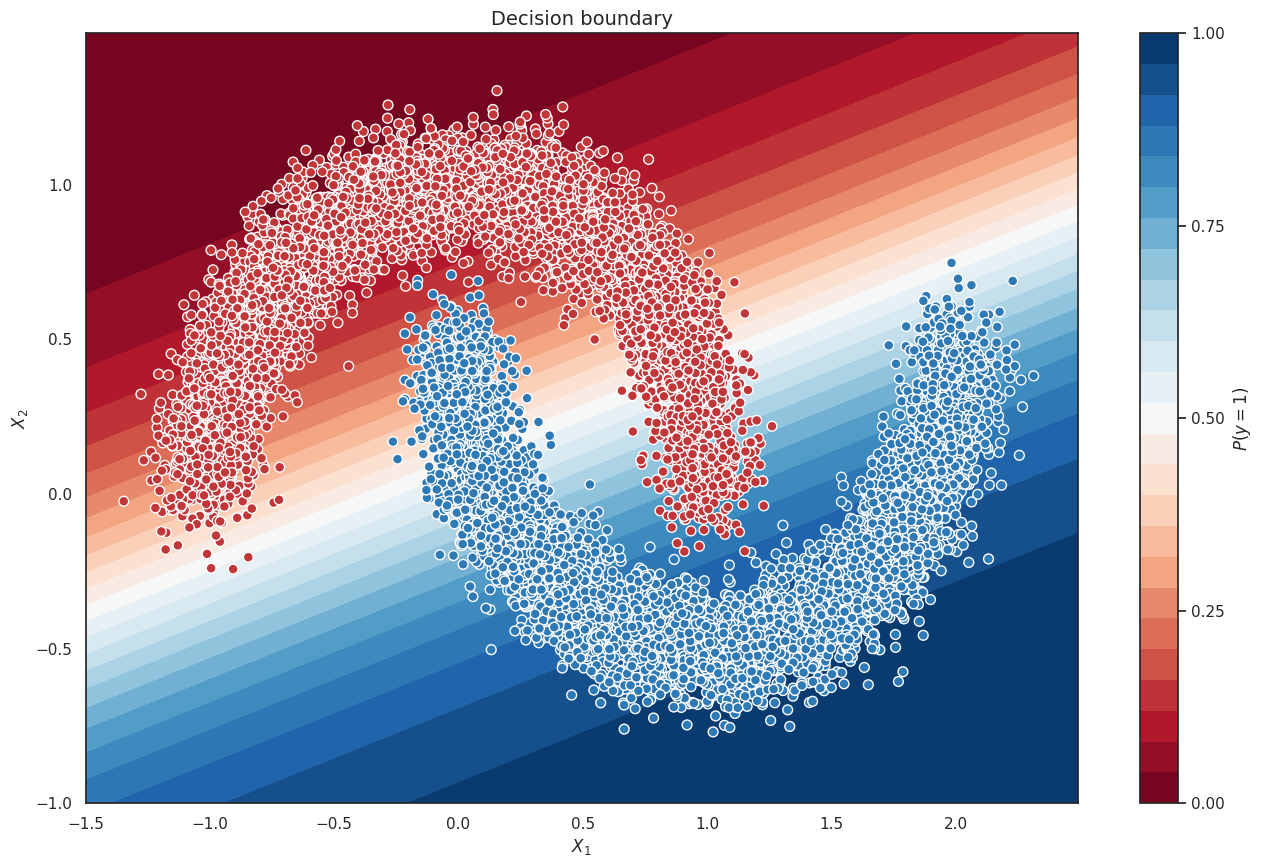

In [39]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [18]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = model(x_batch)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [48]:
from sklearn.metrics import accuracy_score

preds = predict(val_dataloader, linear_regression)
probabilities = (1 / (1 + np.exp(-preds))) > 0.5
probabilities.astype(int)
accuracy_score(y_val, probabilities)

0.8832

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8832

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [49]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

BATCH_SIZE = 16
train_dataloader =  DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_dataloader =  DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:10<00:00, 972kB/s] 


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 151kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.43MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.68MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [50]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [81]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 10),
    activation(),
)

In [82]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [83]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=10, bias=True)
  (4): ELU(alpha=1.0)
)

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [84]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch)
              loss = criterion(outp, y_batch)
              loss.backward()
              optimizer.step()

            else:
              model.eval()
              with torch.no_grad():
                outp = model(x_batch)

            preds = outp.argmax(-1)
            correct = sum(preds == y_batch)
            all = len(preds)
            epoch_correct += correct.item()
            epoch_all += all

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9115166666666666
Loader: valid. Accuracy: 0.9525
Epoch: 2
Loader: train. Accuracy: 0.9567
Loader: valid. Accuracy: 0.961
Epoch: 3
Loader: train. Accuracy: 0.9651333333333333
Loader: valid. Accuracy: 0.9607
Epoch: 4
Loader: train. Accuracy: 0.96965
Loader: valid. Accuracy: 0.9711
Epoch: 5
Loader: train. Accuracy: 0.9749333333333333
Loader: valid. Accuracy: 0.9693
Epoch: 6
Loader: train. Accuracy: 0.9767
Loader: valid. Accuracy: 0.9757
Epoch: 7
Loader: train. Accuracy: 0.9788
Loader: valid. Accuracy: 0.9737
Epoch: 8
Loader: train. Accuracy: 0.9798333333333333
Loader: valid. Accuracy: 0.9734
Epoch: 9
Loader: train. Accuracy: 0.9818666666666667
Loader: valid. Accuracy: 0.9731
Epoch: 10
Loader: train. Accuracy: 0.9820666666666666
Loader: valid. Accuracy: 0.9735


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [85]:
elu_accuracy = accuracy["valid"]

In [86]:
max_epochs = 10
loaders = {"train": train_dataloader, "valid": valid_dataloader}

def test_activation_function(activation):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 128),
        activation(),
        nn.Linear(128, 10),
        activation(),
    )
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                  model.train()
                  optimizer.zero_grad()
                  outp = model(x_batch)
                  loss = criterion(outp, y_batch)
                  loss.backward()
                  optimizer.step()
                else:
                  model.eval()
                  with torch.no_grad():
                    outp = model(x_batch)

                preds = outp.argmax(-1)
                correct = sum(preds == y_batch)
                all = len(preds)
                epoch_correct += correct.item()
                epoch_all += all

            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)

    return accuracy["valid"]

In [87]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Epoch: 1
Loader: train. Accuracy: 0.8737333333333334
Loader: valid. Accuracy: 0.8871
Epoch: 2
Loader: train. Accuracy: 0.89455
Loader: valid. Accuracy: 0.8936
Epoch: 3
Loader: train. Accuracy: 0.9004833333333333
Loader: valid. Accuracy: 0.9141
Epoch: 4
Loader: train. Accuracy: 0.9025833333333333
Loader: valid. Accuracy: 0.9007
Epoch: 5
Loader: train. Accuracy: 0.9046333333333333
Loader: valid. Accuracy: 0.9072
Epoch: 6
Loader: train. Accuracy: 0.90795
Loader: valid. Accuracy: 0.8958
Epoch: 7
Loader: train. Accuracy: 0.9102166666666667
Loader: valid. Accuracy: 0.9089
Epoch: 8
Loader: train. Accuracy: 0.911
Loader: valid. Accuracy: 0.8958
Epoch: 9
Loader: train. Accuracy: 0.9118666666666667
Loader: valid. Accuracy: 0.9127
Epoch: 10
Loader: train. Accuracy: 0.91375
Loader: valid. Accuracy: 0.9195
Epoch: 1
Loader: train. Accuracy: 0.46563333333333334
Loader: valid. Accuracy: 0.5707
Epoch: 2
Loader: train. Accuracy: 0.5768666666666666
Loader: valid. Accuracy: 0.5796
Epoch: 3
Loader: train. 

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

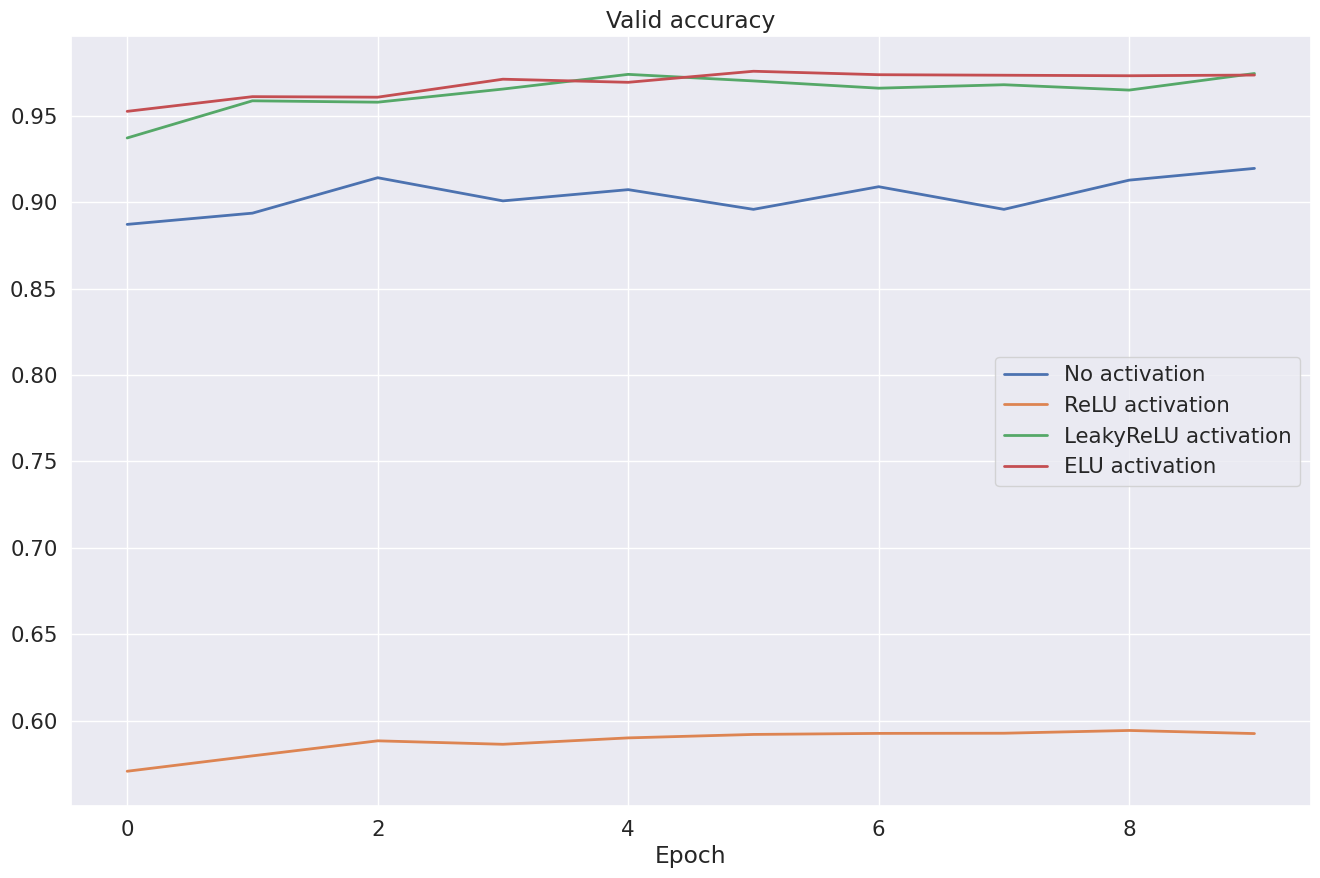

In [88]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

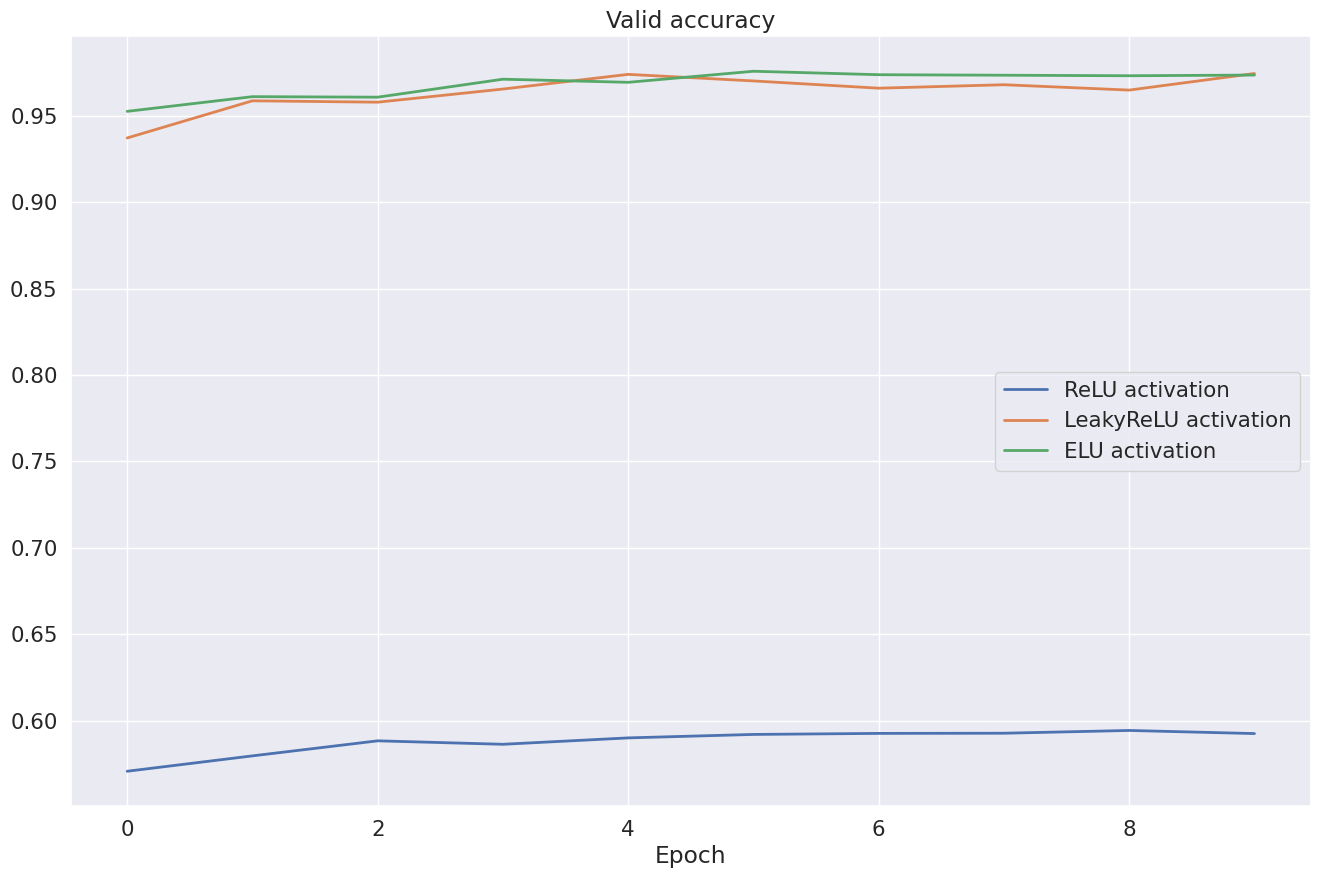

In [89]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** LeakyReLU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [90]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2024-10-27 04:51:59--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   114KB/s    in 0.4s    

2024-10-27 04:52:00 (114 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



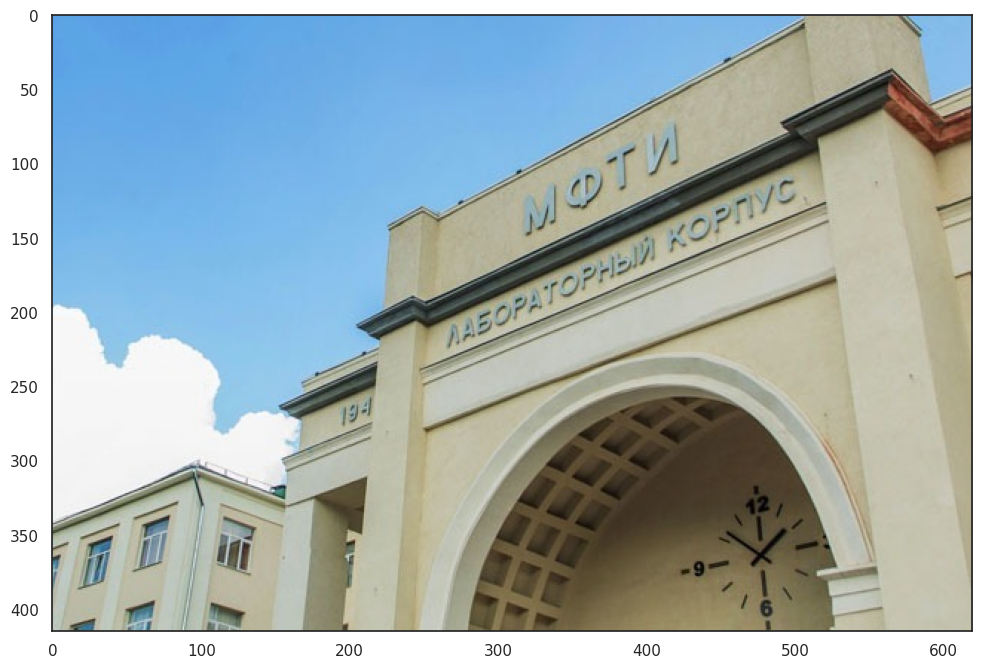

In [91]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте

A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [141]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

kernels = torch.tensor([
    ## А
    [[0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]],

    ## Б
    [[0, 1, 0],
    [0, -2, 0],
    [0, 1, 0]],

    ## В
    [[0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]],

    ## Г
    [[0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]],

    ## Д
    [[0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]],

    ## Е
    [[0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]],
])

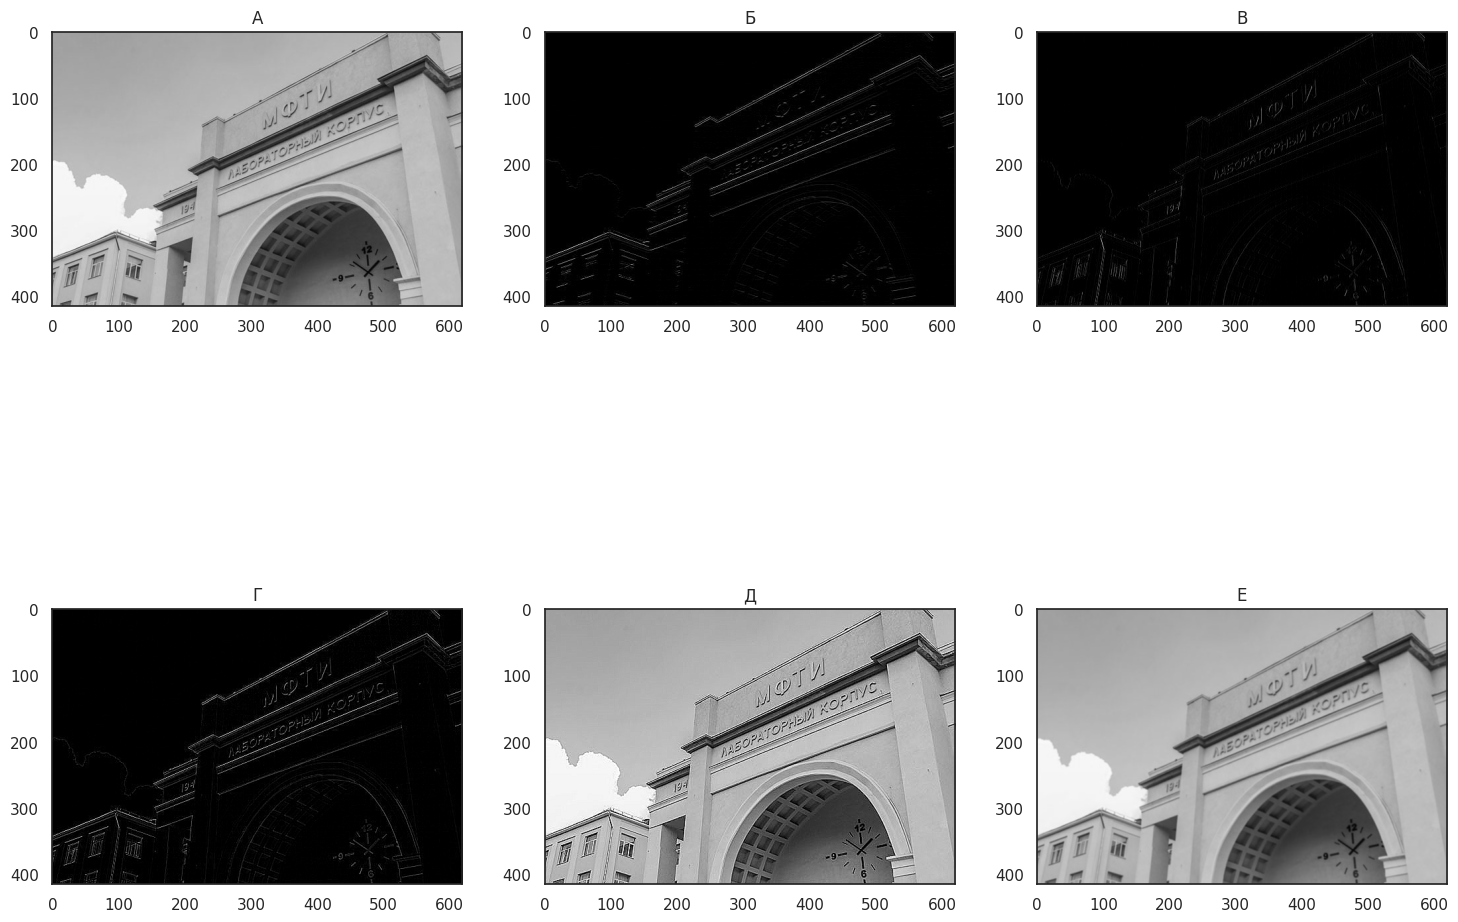

In [153]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(18)
fig.set_figheight(15)

titles = ['А', 'Б', 'В', 'Г', 'Д', 'Е', ]
for i, kernel in enumerate(kernels):
  kernel = kernel.reshape(1, 1, 3, 3).type(torch.float32)
  kernel = kernel.repeat(3, 3, 1, 1)

  result = F.conv2d(img_t, kernel)[0]
  result_np = result.permute(1, 2, 0).numpy() / 256 / 3

  axs[i // 3, i % 3].imshow(result_np)
  axs[i // 3, i % 3].set_title(titles[i])

plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** 1-Е, 2-Д, 3-А, 4-В, 5-Б, 6-Г

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [156]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.act(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)

        return x

In [164]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [165]:
from tqdm import tqdm

count_epochs = 10
loaders = {"train": train_dataloader, "valid": valid_dataloader}
accuracy = {"train": [], "valid": []}

for epoch in range(count_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0

        if k == "train":
          print(f"Epoch: {epoch+1}")

        for x_batch, y_batch in tqdm(train_dataloader):
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)

            preds = outp.argmax(-1)
            correct = sum(preds == y_batch)
            epoch_correct += correct.item()
            epoch_all += len(preds)

        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1


100%|██████████| 3750/3750 [00:45<00:00, 81.83it/s]


Loader: train. Accuracy: 0.9501


100%|██████████| 3750/3750 [00:27<00:00, 138.25it/s]


Loader: valid. Accuracy: 0.9805666666666667
Epoch: 2


100%|██████████| 3750/3750 [00:46<00:00, 80.10it/s]


Loader: train. Accuracy: 0.9816


100%|██████████| 3750/3750 [00:27<00:00, 137.77it/s]


Loader: valid. Accuracy: 0.9841333333333333
Epoch: 3


100%|██████████| 3750/3750 [00:47<00:00, 79.71it/s]


Loader: train. Accuracy: 0.9872833333333333


100%|██████████| 3750/3750 [00:27<00:00, 137.99it/s]


Loader: valid. Accuracy: 0.99115
Epoch: 4


100%|██████████| 3750/3750 [00:47<00:00, 78.82it/s]


Loader: train. Accuracy: 0.9898166666666667


100%|██████████| 3750/3750 [00:27<00:00, 135.39it/s]


Loader: valid. Accuracy: 0.9917166666666667
Epoch: 5


100%|██████████| 3750/3750 [00:46<00:00, 80.54it/s]


Loader: train. Accuracy: 0.9921666666666666


100%|██████████| 3750/3750 [00:26<00:00, 139.27it/s]


Loader: valid. Accuracy: 0.9950333333333333
Epoch: 6


100%|██████████| 3750/3750 [00:46<00:00, 80.72it/s]


Loader: train. Accuracy: 0.9932


100%|██████████| 3750/3750 [00:27<00:00, 138.06it/s]


Loader: valid. Accuracy: 0.9963833333333333
Epoch: 7


100%|██████████| 3750/3750 [00:45<00:00, 82.93it/s]


Loader: train. Accuracy: 0.9938833333333333


100%|██████████| 3750/3750 [00:26<00:00, 140.43it/s]


Loader: valid. Accuracy: 0.9961333333333333
Epoch: 8


100%|██████████| 3750/3750 [00:47<00:00, 78.82it/s]


Loader: train. Accuracy: 0.9949166666666667


100%|██████████| 3750/3750 [00:27<00:00, 137.19it/s]


Loader: valid. Accuracy: 0.9965333333333334
Epoch: 9


100%|██████████| 3750/3750 [00:45<00:00, 82.74it/s]


Loader: train. Accuracy: 0.9955


100%|██████████| 3750/3750 [00:27<00:00, 137.73it/s]


Loader: valid. Accuracy: 0.9965833333333334
Epoch: 10


100%|██████████| 3750/3750 [00:47<00:00, 79.38it/s]


Loader: train. Accuracy: 0.9960333333333333


100%|██████████| 3750/3750 [00:27<00:00, 138.12it/s]

Loader: valid. Accuracy: 0.9975833333333334


In [166]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

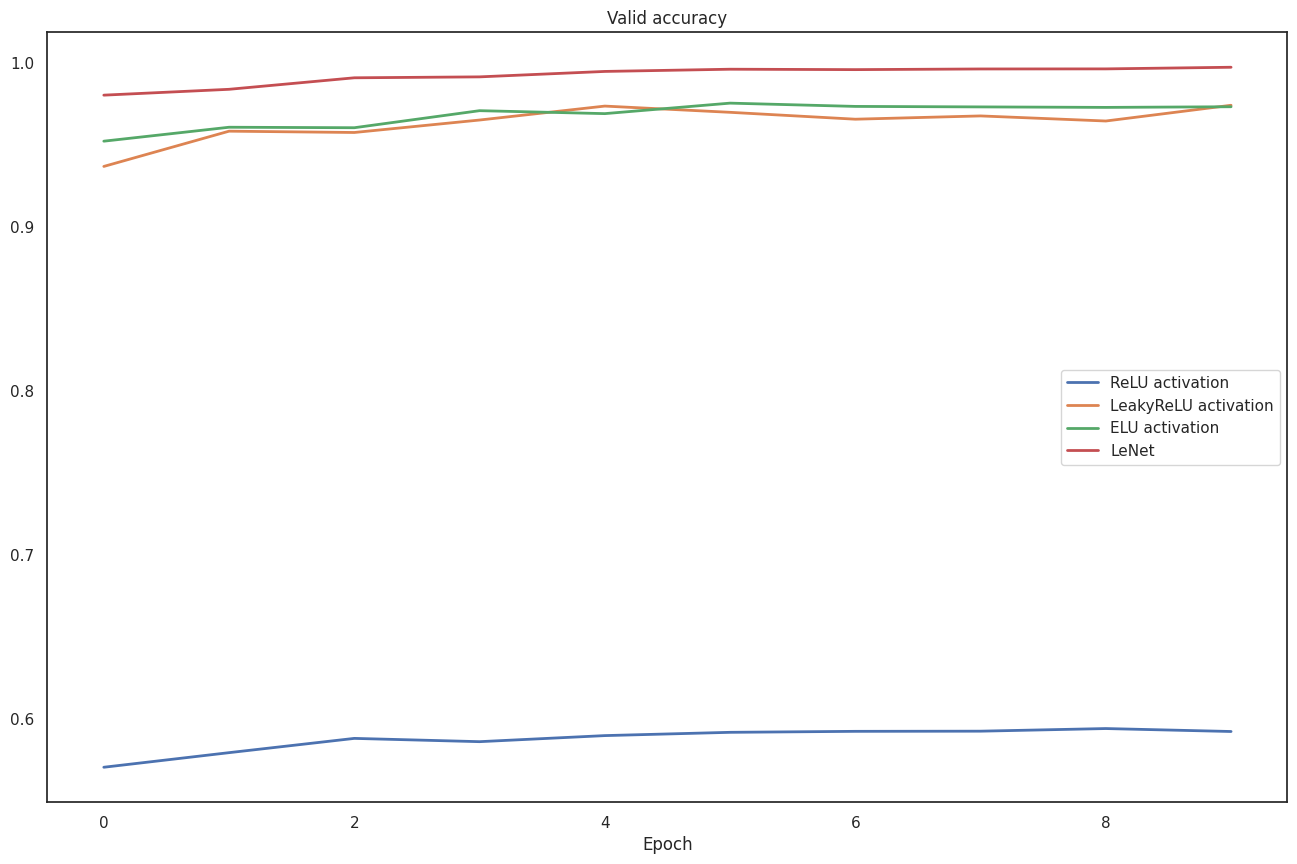

In [167]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [168]:
lenet_accuracy[-1]

0.9975833333333334

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99

---
**Мысли автора**

Дальше тестирую модель своей циферкой)

---

In [236]:
!wget -O 1.png --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1qvDz0IppCnY6896EkIjUOOKRC0Kf1Vys'
!wget -O 2.png --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1uvU-GyRX0Z0zqCmYlHGPxOnJYrNL1XG1'
!wget -O 3.png --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=187G8ggdTN9lx3G7kA14EImhlJfa6naHT'
!wget -O 4.png --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=11HgshaPTry3IN7ur7C9kDtJfVErdEp6M'

will be placed in the single file you specified.

--2024-10-27 07:51:34--  https://drive.google.com/uc?export=download&id=1qvDz0IppCnY6896EkIjUOOKRC0Kf1Vys
Resolving drive.google.com (drive.google.com)... 142.250.157.101, 142.250.157.139, 142.250.157.138, ...
Connecting to drive.google.com (drive.google.com)|142.250.157.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1qvDz0IppCnY6896EkIjUOOKRC0Kf1Vys&export=download [following]
--2024-10-27 07:51:35--  https://drive.usercontent.google.com/download?id=1qvDz0IppCnY6896EkIjUOOKRC0Kf1Vys&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.157.132, 2404:6800:4008:c13::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.157.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 585 [image/png]
Saving to: ‘1.png’

1.png               100%[==================

In [237]:
import torchvision as tv

transformer = tfs.Normalize((0.5), (0.5))

def load_img(path: str):
    img = tv.io.read_image(path, mode=tv.io.ImageReadMode.GRAY)
    img = img.type(torch.float32).reshape(1, 1, 28, 28)
    return transformer(img)

img1 = load_img('./1.png')
img2 = load_img('./2.png')
img3 = load_img('./3.png')
img4 = load_img('./4.png')

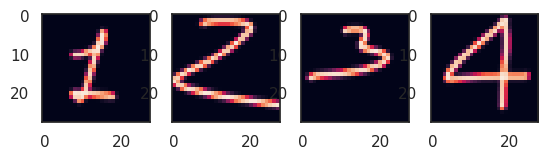

In [238]:
fig, axs = plt.subplots(1, 4)

axs[0].imshow(img1[0][0])
axs[1].imshow(img2[0][0])
axs[2].imshow(img3[0][0])
axs[3].imshow(img4[0][0])

In [240]:
outp1 = model(img1)
outp2 = model(img2)
outp3 = model(img3)
outp4 = model(img4)
print(outp1.argmax(), outp2.argmax(), outp3.argmax(), outp4.argmax())

tensor(1) tensor(1) tensor(2) tensor(4)


---
**Мысли автора**

Ну как то ~так

---